# Workflow for n-artifact clusters

1. **additional artifacts**: 

(a) completely surrounded by artifacts --> artifacts themselves

(b) contiguous to an artifact (or artifact cluster?) and with an artifact index NEAR the artifact index for that city

2. Identify n-artifact clusters (clusters of contiguous artifacts, n>2); make sure that the union has no interior
3. For each cluster, drop all the interior lines and skeletonize
4. Visualize to see if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton

Specify case metadata

In [2]:
case = "Liège"

Read road data

In [3]:
roads = utils.read_parquet_roads(case)

Remove duplicated roads

In [4]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Assign COINS-based information to roads

In [5]:
# %%time
roads, coins = algorithms.common.continuity(roads)

Read **polygons**

In [6]:
fas = momepy.FaceArtifacts(roads)
polygons = fas.polygons.set_crs(roads.crs)

**Iteratively identify polygons that are fully enclosed by artifacts, or that touch artifacts and have a FAI in +1% of threshold, as artifacts**  

In [7]:
# rook neighbors
rook = graph.Graph.build_contiguity(polygons, rook=True)
polygons['neighbors'] = rook.neighbors
prop = 1.01

# polygons are not artifacts,
polygons["is_artifact"] = False
# unless the fai is below the threshold,
polygons.loc[polygons.face_artifact_index < fas.threshold, "is_artifact"] = True

# OR (iteratively)

while True:

    artifact_count_before = sum(polygons.is_artifact)

    # polygons that are enclosed by artifacts
    polygons["enclosed"] = polygons.apply(
        lambda x: len(x.neighbors)>0 and all(polygons.loc[list(x.neighbors), "is_artifact"]), 
        axis = 1
    )
    # setting is_artifact to True
    polygons.loc[polygons.enclosed, "is_artifact"] = True

    # polygons that are touching artifacts and within x% of fai
    polygons["touching"] = polygons.apply(
        lambda x: len(x.neighbors)>0 and any(polygons.loc[list(x.neighbors), "is_artifact"]), 
        axis = 1
    )

    # setting is_artifact to True
    polygons.loc[
        (polygons.touching == True) & (polygons.face_artifact_index < fas.threshold * prop),
        "is_artifact"
    ] = True

    artifact_count_after = sum(polygons.is_artifact)
    if artifact_count_after == artifact_count_before:
        break

In [8]:
print(artifact_count_after)

3662


In [ ]:
# m = roads.explore(
#     "coins_len",
#     k=20,
#     scheme="quantiles",
#     tiles="cartodb positron",
#     prefer_canvas=True,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
# )
# polygons[polygons.is_artifact].explore(m=m, name = "All artifacts", color = "red")
# polygons[polygons.face_artifact_index < fas.threshold].explore(m=m, name = "Initial artifacts", color = "green")
# #nodes.explore(m=m, name="Nodes", color="blue", marker_size=250)
# folium.LayerControl().add_to(m)
# plugins.MousePosition().add_to(m)

# m

**Get artifacts gdf**

In [9]:
artifacts = polygons[polygons.is_artifact][["geometry"]].copy()
artifacts["id"] = artifacts.index
artifacts.head()

,geometry,id
0,"POLYGON ((687053.642 5615820.989, 687059.393 5...",0
2,"POLYGON ((687053.642 5615820.989, 687051.723 5...",2
4,"POLYGON ((677400.757 5613704.998, 677429.096 5...",4
7,"POLYGON ((682353.554 5612410.841, 682350.603 5...",7
10,"POLYGON ((685360.558 5609766.62, 685359.515 56...",10


Remove edges fully within the artifact (dangles).

In [10]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Get nodes from the network.

In [11]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

Link nodes to artifacts

In [12]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Compute number of nodes per artifact

In [13]:
artifacts["node_count"] = intersects.sum(axis=0)

Apply additional filters to remove artifacts that are not suitable for simplification. These may be artifacts that:
- are too large in size
- are part of a larger intersection that may need different methods of simplification

In [14]:
area_threshold = 1250  # this is hard to determine but it can be done iteratively using different thresholds
circular_compactness_threshold = 0.15  # same as above

rook = graph.Graph.build_contiguity(artifacts, rook=True)

**keeping only size n>2 clusters!**

In [15]:
artifacts['comp'] = rook.component_labels
counts = artifacts['comp'].value_counts()
artifacts = artifacts.loc[artifacts['comp'].isin(counts[counts>2].index)].copy()

Compute number of stroke groups per artifact.

In [17]:
def _get_stroke_info(artifacts, roads):
    strokes = []
    c_ = []
    e_ = []
    s_ = []
    for geom in artifacts.geometry:
        singles = 0
        ends = 0
        edges = roads.iloc[roads.sindex.query(geom, predicate="covers")]
        if (  # roundabout special case
            edges.coins_group.nunique() == 1
            and edges.shape[0] == edges.coins_count.iloc[0]
        ):
            singles = 1
            mains = 0
        else:
            all_ends = edges[edges.coins_end]
            mains = edges[
                ~edges.coins_group.isin(all_ends.coins_group)
            ].coins_group.nunique()

            visited = []
            for coins_count, group in zip(
                all_ends.coins_count, all_ends.coins_group, strict=True
            ):
                if (group not in visited) and (
                    coins_count == (edges.coins_group == group).sum()
                ):
                    singles += 1
                    visited.append(group)
                elif group not in visited:
                    ends += 1
                    # do not add to visited as they may be disjoint within the artifact
        strokes.append(edges.coins_group.nunique())
        c_.append(mains)
        e_.append(ends)
        s_.append(singles)
    return strokes, c_, e_, s_


strokes, c_, e_, s_ = _get_stroke_info(artifacts, roads)
artifacts["stroke_count"] = strokes
artifacts["C"] = c_
artifacts["E"] = e_
artifacts["S"] = s_

Filer artifacts caused by non-planar intersections.

In [18]:
artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
a_idx, r_idx = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
artifacts.iloc[np.unique(a_idx), -1] = True

**Remove (for now) the clusters that contain at least one non-planar component** (we will deal with them later, ...?)

In [19]:
# non_planar_cluster: number of non-planar artifacts per cluster
artifacts["non_planar_cluster"] = artifacts.apply(lambda x: sum(artifacts.loc[artifacts["comp"]==x.comp]["non_planar"]), axis = 1)
# dealing with the non-planar later!
artifacts = artifacts[artifacts.non_planar_cluster == 0].copy()

Count intersititial nodes (primes).

In [20]:
artifacts["interstitial_nodes"] = artifacts.node_count - artifacts[["C", "E", "S"]].sum(
    axis=1
)

Define the type label.

In [21]:
ces_type = []
for x in artifacts[["node_count", "C", "E", "S"]].itertuples():
    ces_type.append(f"{x.node_count}{'C' * x.C}{'E' * x.E}{'S' * x.S}")
artifacts["ces_type"] = ces_type

In [54]:
artifacts.head(20)

,geometry,id,node_count,comp,stroke_count,C,E,S,non_planar,non_planar_cluster,interstitial_nodes,ces_type
2,"POLYGON ((687053.642 5615820.989, 687051.723 5...",2,8,0,4,1,2,2,False,0,3,8CEESS
55,"POLYGON ((677900.684 5610100.028, 677900.006 5...",55,4,11,4,2,0,2,False,0,0,4CCSS
56,"POLYGON ((677901.299 5610083.598, 677900.684 5...",56,4,11,4,2,0,2,False,0,0,4CCSS
63,"POLYGON ((679348.863 5609237.495, 679264.455 5...",63,4,13,3,1,1,1,False,0,1,4CES
64,"POLYGON ((679264.455 5609252.639, 679348.863 5...",64,4,13,3,1,0,2,False,0,1,4CSS
65,"POLYGON ((679344.914 5609222.712, 679348.863 5...",65,5,13,2,1,1,0,False,0,3,5CE
70,"POLYGON ((682110.539 5613520.188, 682128.966 5...",70,4,15,4,0,4,0,False,0,0,4EEEE
97,"POLYGON ((673785.405 5617205.128, 673813.319 5...",97,6,18,4,2,0,2,False,0,2,6CCSS
108,"POLYGON ((680804.862 5615845.162, 680819.447 5...",108,5,20,3,1,1,1,False,0,2,5CES
117,"POLYGON ((685037.929 5618924.548, 685026.517 5...",117,3,21,2,0,1,1,False,0,1,3ES


**Skeletonization attempts**

<Axes: >

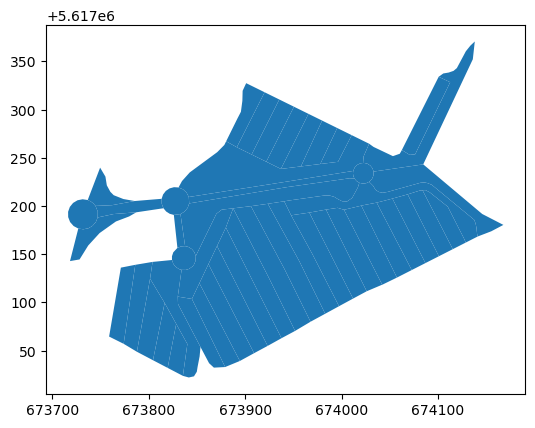

In [57]:
mycomp = 18
artifacts[artifacts.comp == mycomp].plot()

In [59]:
nodes.head()

,x,y,degree,nodeID,geometry
0,687053.642439,5.615821e+06,3,0,POINT (687053.642 5615820.989)
1,687059.393388,5.615804e+06,3,1,POINT (687059.393 5615803.607)
2,687051.723154,5.615826e+06,3,2,POINT (687051.723 5615826.386)
3,677429.096116,5.613705e+06,3,3,POINT (677429.096 5613705.29)
4,677400.756812,5.613705e+06,3,4,POINT (677400.757 5613704.998)


find nodes that 

* have degree n 
* on the boundary of cluster_geom
* intersect n-2 orange

if remove before skel:
* linemerged boundary minus nodes-to-keep plus tiny buffer gives sequences of road segments to merge
* create queen contiguity graph on roads segments minus tiny buffers, from there component label that assigns to original segments pre-bufferlip
* dissolve
* pass as input for skel

if remove after skel:
* remove lines from skelet that intersect these nodes, then remove dangles

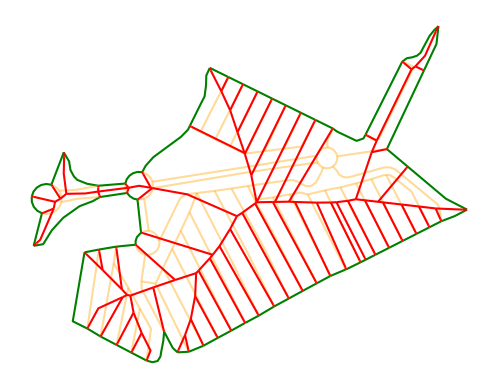

In [58]:
cluster_geom = artifacts[artifacts.comp == mycomp].union_all()
edges_outside = roads.iloc[roads.sindex.query(cluster_geom.boundary, predicate="covers")]
edges_within = roads.iloc[roads.sindex.query(cluster_geom, predicate = "contains")]
fig, ax = plt.subplots(1,1)
edges_outside.plot(ax=ax, color = "green")
edges_within.plot(ax=ax, color = "orange", alpha=.4)
skel, _ = voronoi_skeleton(
    edges_outside.geometry,
    cluster_geom
)
gpd.GeoSeries(skel).plot(ax=ax, color = "red")
ax.set_axis_off()

In [ ]:
# def classify_interline(mycluster, artifacts, roads):

#     # get the cluster geometry
#     cluster_geom = artifacts[artifacts.comp == mycluster].union_all()

#     # find the road segment that is contained within the cluster geometry
#     road_contained = roads.sindex.query(cluster_geom, predicate="contains")
    
#     # make sure we have uniquely identified the road segment
#     assert len(road_contained)==1 

#     # return the ID of the road segment (to potentially drop later) and coins_end True/False    
#     return road_contained[0], roads.loc[road_contained]["coins_end"].values[0]

# interlines = artifacts.comp.apply(lambda x: classify_interline(x, artifacts, roads))
# artifacts["inter_road"] = [v[0] for v in interlines]
# artifacts["inter_coins_end"] = [v[1] for v in interlines]
# artifacts["drop_interline"] = artifacts["inter_coins_end"]

In [ ]:
# # if one of the 2 artifacts is of type 0C0EnS, then no matter whether inter_coins_end is True or False! it will always be S
# comps_with_s = list(artifacts[(artifacts.C == 0) & (artifacts.E == 0)].comp)
# artifacts.loc[artifacts["comp"].isin(comps_with_s), "drop_interline"] = True